# CS 440 Final Project
Project: **NLBSE 2025 Code Comment Classification**

Members (Team Overfitted):
 - Erik Cooper
 - Seth Harling
## Vision
This tool competition involves building and training 3 multi-label classification models for code comments. These comments fall in to different categories for the different languages (Java, Python, and Pharo). These categories include comments for summarization, development notes, intent, and usage.

For our project, we chose to run with a strongly langauge processing approach, trying our best to ignore formatting as hints to the category. This is one of the reasons why we chose to use GPT-2 as our base model.

When searching for pretrained NLP models, we were presented with many options. The main ones we considered were variations of BERT (RoBERTa for one), ELMo, UniLM, and GPT. There were a couple properties we were specifically looking for in a model for this project. We wanted a model that would work well on a classification problem, and we wanted a smaller model that would take less time to train so we could spend more time learning how to work the NLPs than waiting for it to work.

With this, we settled on the smallest size of [GPT-2](https://huggingface.co/openai-community/gpt2) with 124M parameters. This number of parameters felt in line with the scope of our project, plus GPT is a rather famous model that most people have at least heard about. We thought that working with something somewhat familiar would help with learning how this all works. Though, to make the tuning process a little quicker, we use [distilgpt2](https://huggingface.co/distilbert/distilgpt2) to reduce our training times by 50% with its lower 82M parameters.

## Attempted improvements
 - Label embeddings in GPT2Model
   - Resulted in overall accuracy of ~50%
 - Various forms of preprocessing
   - Included removing formatting, changing between truncation in the middle or end, excluding sections within formatting
   - Resulted in minimal negative effect. Could be explored further
 - Included label in input during training.
  - Resulted in dependency on special tokens. Ended in worse results. Could be due to bad implementation.
## Improvements to try
 - Data augmentation
   - Translating data between languages to get more inputs.

### Imports

In [1]:
from datasets import load_dataset
import numpy as np
import torch
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, multilabel_confusion_matrix
from transformers import (GPT2Config,
                          GPT2Tokenizer,
                          GPT2Model,
                          AdamW, 
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification)
import re
from lion_pytorch import Lion

Using TensorFlow backend.


### Defining string constants

In [2]:
# From challenge ()
classification_langs = ['java', 'python', 'pharo']
classification_labels = {
    'java': ['summary', 'Ownership', 'Expand', 'usage', 'Pointer', 'deprecation', 'rational'],
    'python': ['Usage', 'Parameters', 'DevelopmentNotes', 'Expand', 'Summary'],
    'pharo': ['Keyimplementationpoints', 'Example', 'Responsibilities', 'Classreferences', 'Intent', 'Keymessages', 'Collaborators']
}
lang_learning_rates = {
    'java': 1e-5,
    'python': 1e-4,
    'pharo': 1e-4
}
lang_epochs = {
    'java': 2,
    'python': 5,
    'pharo': 5
}
lang_weights = {
    'java': [1.0, 1.0, 1.5, 1.0, 1.0, 1.0, 1.5],
    'python': [1.0, 1.0, 1.0, 1.0, 1.0],
    'pharo': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
}
lang_thresholds = {
    'java': [0.5, 0.5, 0.25, 0.5, 0.5, 0.5, 0.2],
    'python': [0.5, 0.5, 0.5, 0.5, 0.5],
    'pharo': [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
}

### Parameters

In [3]:
model_name = 'distilgpt2' # model name
add_class_name = False # add class name to the input text

### Preprocessing functions

In [4]:
def preprocess_java(comment, class_name, labels=None):
    # Create dataset object
    output = []
    
    for i in range(len(comment)):
        text = comment[i]
        
        # remove entirety of html lists
        # text = re.sub(r'<ol>[.\s\S]*?<\/ol>', '', text)
        
        # remove html tags
        text = re.sub(r'<.*?>', '', text)
        
        # remove bullets
        #text = re.sub(r'\s\*', '', text)
        
        # remove bulleted lines
        #text = re.sub(r'\n\s*\*.*', '', text)
        
        # remove curly braced sections
        #text = re.sub(r'\{.*?\}', '', text)
        
        # remove // comments
        # text = re.sub(r'\s*\/\/.*', '', text)
        
        # remove formatting for // comments
        # text = re.sub(r'\/\/', '', text)
        
        # remove formatting for /* */ comments
        # text = re.sub(r'\/\*.|\*\/', '', text)
        
        # remove multiple spaces
        text = re.sub(r'\s+', ' ', text)
        
        # Add class name
        if add_class_name:
            text = class_name[i] + ': ' + text
        
        # truncate middle
        #if (len(text) > max_length):
        #    text = text[:(int(max_length/2)-4)] + ' ... ' + text[-(int(max_length/2)-4):]
        
        # truncate end
        if (len(text) > max_length):
            text = text[:max_length]
        
        # Build dictionary
        if labels is not None:
            output.append({
                'text': text,
                'label': labels[i]
            })
        else:
            output.append({
                'text': text,
                'label': [0, 0, 0, 0, 0, 0, 0]
            })
    
    return output

In [5]:
def preprocess_python(comment, class_name, labels=None):
    output = []
    
    for i in range(len(comment)):
        text = comment[i]
        
        # Add class name
        #text = class_name[i] + ': ' + text
        
        # truncate
        #if (len(text) > max_length):
        #    text = text[:(int(max_length/2)-4)] + ' ... ' + text[-(int(max_length/2)-4):]
        
        # truncate end
        if (len(text) > max_length):
            text = text[:max_length]
        
        # Build dictionary
        if labels is not None:
            output.append({
                'text': text,
                'label': labels[i]
            })
        else:
            output.append({
                'text': text,
                'label': [0, 0, 0, 0, 0]
            })
    
    return output

In [6]:
def preprocess_pharo(comment, class_name, labels=None):
    output = []
    
    for i in range(len(comment)):
        text = comment[i]
        
        # Add class name
        #text = class_name[i] + ': ' + text
        
        # truncate
        #if (len(text) > max_length):
        #    text = text[:(int(max_length/2)-4)] + ' ... ' + text[-(int(max_length/2)-4):]
        
        # truncate end
        if (len(text) > max_length):
            text = text[:max_length]
        
        # Build dictionary
        if labels is not None:
            output.append({
                'text': text,
                'label': labels[i]
            })
        else:
            output.append({
                'text': text,
                'label': [0, 0, 0, 0, 0, 0, 0]
            })
    
    return output

### GPT2 Collator

In [7]:
# Collator object for GPT2, which will tokenize the text
class GPT2_collator(object):
    def __init__(self, tokenizer, max_length):
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __call__(self, sequences):
        texts = [sequence['text'] for sequence in sequences]
        labels = [sequence['label'] for sequence in sequences]
        
        inputs = self.tokenizer(text=texts, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_length)
        inputs.update({'labels': torch.tensor(labels)})
        
        return inputs

### Train, Validate, and Predict

In [8]:
# Training function, updates model weights
def train(model, dataloader, optimizer, scheduler, loss_fn, thresholds, max_batches=None):
    global device
    
    model.train()
    
    pred_labels = []
    true_labels = []
    total_loss = 0
    
    batches_processed = 0
    
    for batch in tqdm(dataloader, total=len(dataloader)):
        if max_batches is not None and batches_processed >= max_batches:
            break
        
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        labels = batch['labels'].to(device)
        
        outputs = model(**inputs)
        
        loss = loss_fn(outputs.logits, labels.float())
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
        probs = torch.sigmoid(outputs.logits)
        preds = (probs > thresholds).int()
        
        pred_labels.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
        
        batches_processed += 1
    
    avg_epoch_loss = total_loss / batches_processed
    
    return pred_labels, true_labels, avg_epoch_loss

In [9]:
# For validation, no updating
def validate(model, dataloader, loss_fn, thresholds, max_batches=None):
    global device
    
    model.eval()
    
    pred_labels = []
    true_labels = []
    total_loss = 0
    
    batches_processed = 0
    
    for batch in tqdm(dataloader, total=len(dataloader)):
        if max_batches is not None and batches_processed >= max_batches:
            break
        
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        labels = batch['labels'].to(device)
        
        outputs = model(**inputs)
        
        loss = loss_fn(outputs.logits, labels.float())
        total_loss += loss.item()
        
        probs = torch.sigmoid(outputs.logits)
        preds = (probs > thresholds).int()
        
        pred_labels.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
        
        batches_processed += 1
    
    avg_epoch_loss = total_loss / batches_processed
    
    return pred_labels, true_labels, avg_epoch_loss

In [10]:
# Inferencing function
def predict(model, dataloader, thresholds):
    global device
    
    model.eval()
    
    pred_labels = []
    probs_list = []
    
    for batch in tqdm(dataloader, total=len(dataloader)):
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        
        outputs = model(**inputs)
        
        probs = torch.sigmoid(outputs.logits)
        preds = (probs > thresholds).int()
        
        probs_list.extend(probs.detach().cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())
    
    return pred_labels, probs_list

### Setup

In [11]:
# Loading dataset
ds = load_dataset('NLBSE/nlbse25-code-comment-classification')

In [12]:
# Augmenting dataset
# TODO: Add augmentation, python and pharo are sparse

In [13]:
# Setting up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [14]:
# Model setup and training
def build_model(lang, save=False, optimizer='Lion', learning_rate=None, num_epochs=None, batch_size=8, max_length=512):
    global device
    
    num_labels = len(classification_labels[lang])
    
    if learning_rate is None:
        learning_rate = lang_learning_rates[lang]
    if num_epochs is None:
        num_epochs = lang_epochs[lang]
    
    # Setup
    print('Setting config...')
    model_config = GPT2Config.from_pretrained(
        model_name,
        num_labels=num_labels,
        id2label={str(i): label for i, label in enumerate(classification_labels[lang])},
        label2id={label: i for i, label in enumerate(classification_labels[lang])},
        problem_type='multi_label_classification'
    )

    print('Loading tokenizer...')
    tokenizer = GPT2Tokenizer.from_pretrained(model_name)
    tokenizer.padding_side = 'left'
    tokenizer.pad_token = tokenizer.eos_token

    print('Loading model...')
    model = GPT2ForSequenceClassification.from_pretrained(model_name, config=model_config)
    model.resize_token_embeddings(len(tokenizer))
    model.config.pad_token_id = tokenizer.eos_token_id
    model.to(device)
    
    collator = GPT2_collator(tokenizer, max_length)
    
    # Prepare data
    print('Preparing data...')
    if lang == 'java':
        train_data = preprocess_java(ds['java_train']['comment_sentence'], ds['java_train']['class'], ds['java_train']['labels'])
        eval_data = preprocess_java(ds['java_test']['comment_sentence'], ds['java_train']['class'], ds['java_test']['labels'])
    elif lang == 'python':
        train_data = preprocess_python(ds['python_train']['comment_sentence'], ds['python_train']['class'], ds['python_train']['labels'])
        eval_data = preprocess_python(ds['python_test']['comment_sentence'], ds['python_train']['class'], ds['python_test']['labels'])
    elif lang == 'pharo':
        train_data = preprocess_pharo(ds['pharo_train']['comment_sentence'], ds['pharo_train']['class'], ds['pharo_train']['labels'])
        eval_data = preprocess_pharo(ds['pharo_test']['comment_sentence'], ds['pharo_train']['class'], ds['pharo_test']['labels'])
    
    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collator)
    eval_dataloader = torch.utils.data.DataLoader(eval_data, batch_size=batch_size, shuffle=False, collate_fn=collator)
    
    # Training
    print('Training...')
    opt = None
    if optimizer == 'AdamW':
        opt = AdamW(model.parameters(), lr = learning_rate, eps = 1e-8, weight_decay=0.01)
    elif optimizer == 'Lion':
        opt = Lion(model.parameters(), lr = learning_rate)
    else:
        raise ValueError('Invalid optimizer ' + optimizer)
    total_steps = len(train_dataloader) * num_epochs
    scheduler = get_linear_schedule_with_warmup(opt, num_warmup_steps=100, num_training_steps=total_steps)
    loss_fn = torch.nn.BCEWithLogitsLoss(weight=torch.tensor(lang_weights[lang]).to(device))
    thresholds = torch.tensor(lang_thresholds[lang]).to(device)
    
    loss_list = []
    accuracy_list = []
    eval_loss_list = []
    eval_accuracy_list = []

    max_batches = None # Set to None to run all batches, or a number to run a limited number of batches for testing
    for epoch in tqdm(range(num_epochs)):
        train_labels, true_labels, train_loss = train(model, train_dataloader, opt, scheduler, loss_fn, thresholds, max_batches)
        train_accuracy = accuracy_score(true_labels, train_labels)
        loss_list.append(train_loss)
        accuracy_list.append(train_accuracy)
        print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss}, Train Accuracy: {train_accuracy}')
        
        eval_labels, true_labels, eval_loss = validate(model, eval_dataloader, loss_fn, thresholds, max_batches)
        eval_accuracy = accuracy_score(true_labels, eval_labels)
        eval_loss_list.append(eval_loss)
        eval_accuracy_list.append(eval_accuracy)
        print(f'Epoch {epoch+1}/{num_epochs} - Eval Loss:  {eval_loss}, Eval Accuracy:  {eval_accuracy}')
    
    # Save model
    if save:
        model.save_pretrained(f'./models/gpt2-{lang}')
        tokenizer.save_pretrained(f'./models/gpt2-{lang}')
    
    return model, tokenizer, loss_list, accuracy_list, eval_loss_list, eval_accuracy_list

## Building our Models

In [15]:
optimizer = 'Lion'
batch_size = 8
max_length = 256

from_pretrained = False

if from_pretrained:
    java_model = GPT2ForSequenceClassification.from_pretrained('./models/gpt2-java')
    java_tokenizer = GPT2Tokenizer.from_pretrained('./models/gpt2-java')
    python_model = GPT2ForSequenceClassification.from_pretrained('./models/gpt2-python')
    python_tokenizer = GPT2Tokenizer.from_pretrained('./models/gpt2-python')
    pharo_model = GPT2ForSequenceClassification.from_pretrained('./models/gpt2-pharo')
    pharo_tokenizer = GPT2Tokenizer.from_pretrained('./models/gpt2-pharo')
else:
    java_model, java_tokenizer, java_loss_list, java_accuracy_list, java_eval_loss_list, java_eval_accuracy_list = build_model('java', save=False, optimizer=optimizer, batch_size=batch_size, max_length=max_length)
    python_model, python_tokenizer, python_loss_list, python_accuracy_list, python_eval_loss_list, python_eval_accuracy_list = build_model('python', save=False, optimizer=optimizer, batch_size=batch_size, max_length=max_length)
    pharo_model, pharo_tokenizer, pharo_loss_list, pharo_accuracy_list, pharo_eval_loss_list, pharo_eval_accuracy_list = build_model('pharo', save=False, optimizer=optimizer, batch_size=batch_size, max_length=max_length)

Setting config...
Loading tokenizer...


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading model...
Preparing data...
Training...


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/952 [00:00<?, ?it/s]

Epoch 1/2 - Train Loss: 0.2701964039681284, Train Accuracy: 0.5514841082216969


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch 1/2 - Eval Loss:  0.149479884956101, Eval Accuracy:  0.7605797101449275


  0%|          | 0/952 [00:00<?, ?it/s]

Epoch 2/2 - Train Loss: 0.1167904922704187, Train Accuracy: 0.800367743630155


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch 2/2 - Eval Loss:  0.15998088569176616, Eval Accuracy:  0.7431884057971014
Setting config...
Loading tokenizer...


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading model...
Preparing data...
Training...


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

Epoch 1/5 - Train Loss: 0.46781074887110013, Train Accuracy: 0.16932059447983014


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 1/5 - Eval Loss:  0.4186546333572444, Eval Accuracy:  0.3620689655172414


  0%|          | 0/236 [00:00<?, ?it/s]

Epoch 2/5 - Train Loss: 0.3149139433783495, Train Accuracy: 0.5207006369426752


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 2/5 - Eval Loss:  0.4231308889483996, Eval Accuracy:  0.45073891625615764


  0%|          | 0/236 [00:00<?, ?it/s]

Epoch 3/5 - Train Loss: 0.18628135284258968, Train Accuracy: 0.7547770700636943


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 3/5 - Eval Loss:  0.5439872699333173, Eval Accuracy:  0.47044334975369456


  0%|          | 0/236 [00:00<?, ?it/s]

Epoch 4/5 - Train Loss: 0.09784129232373405, Train Accuracy: 0.8683651804670913


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 4/5 - Eval Loss:  0.657514055350832, Eval Accuracy:  0.46551724137931033


  0%|          | 0/236 [00:00<?, ?it/s]

Epoch 5/5 - Train Loss: 0.05459637894054433, Train Accuracy: 0.9240976645435244


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch 5/5 - Eval Loss:  0.8168148445148095, Eval Accuracy:  0.4827586206896552
Setting config...
Loading tokenizer...
Loading model...


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Preparing data...
Training...


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

Epoch 1/5 - Train Loss: 0.37082308338829345, Train Accuracy: 0.25115562403698


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 1/5 - Eval Loss:  0.29040340273766907, Eval Accuracy:  0.314878892733564


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch 2/5 - Train Loss: 0.2737121374969102, Train Accuracy: 0.4399075500770416


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 2/5 - Eval Loss:  0.2633060887959358, Eval Accuracy:  0.44982698961937717


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch 3/5 - Train Loss: 0.18961237703501446, Train Accuracy: 0.6417565485362096


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 3/5 - Eval Loss:  0.29820850723095843, Eval Accuracy:  0.5743944636678201


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch 4/5 - Train Loss: 0.10785478742241837, Train Accuracy: 0.8166409861325116


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 4/5 - Eval Loss:  0.37795748289775205, Eval Accuracy:  0.5640138408304498


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch 5/5 - Train Loss: 0.06531891672432057, Train Accuracy: 0.8798151001540832


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 5/5 - Eval Loss:  0.46634935982827397, Eval Accuracy:  0.5605536332179931


In [23]:

# Do classification report
def do_classification_report(model, tokenizer, lang):
    eval_data = preprocess_java(ds[f'{lang}_test']['comment_sentence'], ds[f'{lang}_train']['class'], ds[f'{lang}_test']['labels'])
    eval_dataloader = torch.utils.data.DataLoader(eval_data, batch_size=batch_size, shuffle=False, collate_fn=GPT2_collator(tokenizer, max_length))
    eval_labels, eval_probs = predict(model, eval_dataloader, torch.tensor(lang_thresholds[lang]).to(device))
    eval_labels = np.array(eval_labels)
    eval_probs = np.array(eval_probs)
    true_labels = np.array([sequence['label'] for sequence in eval_data])
    report = classification_report(true_labels, eval_labels, target_names=classification_labels[lang])
    return eval_labels, eval_probs, true_labels, report

java_eval_labels, java_eval_probs, java_true_labels, java_report = do_classification_report(java_model, java_tokenizer, 'java')
python_eval_labels, python_eval_probs, python_true_labels, python_report = do_classification_report(python_model, python_tokenizer, 'python')
pharo_eval_labels, pharo_eval_probs, pharo_true_labels, pharo_report = do_classification_report(pharo_model, pharo_tokenizer, 'pharo')

  0%|          | 0/216 [00:00<?, ?it/s]

c:\Users\Erik\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  0%|          | 0/51 [00:00<?, ?it/s]

c:\Users\Erik\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  0%|          | 0/37 [00:00<?, ?it/s]

c:\Users\Erik\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [53]:
# Combine reports into single pandas dataframe
def report_to_df(report, lang):
    lines = report.split('\n')
    data = []
    for line in lines[2:-5]:
        row = line.split()
        if len(row) == 0:
            continue
        data.append(row)
    df = pd.DataFrame(data, columns=['cat', 'precision', 'recall', 'f1', 'support'])
    df.insert(0, 'lan', lang)
    df = df.iloc[:, :-1]
    return df
        

java_df = report_to_df(java_report, 'java')
python_df = report_to_df(python_report, 'python')
pharo_df = report_to_df(pharo_report, 'pharo')
combined_df = pd.concat([java_df, python_df, pharo_df])
combined_df


,lan,cat,precision,recall,f1
0,java,summary,0.90,0.89,0.89
1,java,Ownership,1.00,1.00,1.00
2,java,Expand,0.25,0.52,0.34
3,java,usage,0.86,0.81,0.83
4,java,Pointer,0.79,0.92,0.85
5,java,deprecation,1.00,0.60,0.75
6,java,rational,0.22,0.44,0.29
0,python,Usage,0.64,0.60,0.62
1,python,Parameters,0.65,0.68,0.67
2,python,DevelopmentNotes,0.32,0.32,0.32


In [73]:
# Compare with baseline results summary
# load baseline results
baseline_results = pd.read_csv('baseline_results_summary.csv')

# Get difference from baseline
def get_diff_df(baseline_df, eval_df):
    diff_df = eval_df.copy()
    diff_df['baseline_precision'] = baseline_df['precision']
    diff_df['baseline_recall'] = baseline_df['recall']
    diff_df['baseline_f1'] = baseline_df['f1']
    diff_df['precision_diff'] = diff_df['precision'].astype(float) - diff_df['baseline_precision'].astype(float)
    diff_df['recall_diff'] = diff_df['recall'].astype(float) - diff_df['baseline_recall'].astype(float)
    diff_df['f1_diff'] = diff_df['f1'].astype(float) - diff_df['baseline_f1'].astype(float)
    # delete all but diff columns
    diff_df = diff_df[['lan', 'cat', 'precision_diff', 'recall_diff', 'f1_diff']]
    diff_df = diff_df.reset_index(drop=True)
    return diff_df

diff_df = get_diff_df(baseline_results, combined_df)
# style dataframe to make cells green if positive, red if negative
def highlight_diff(val):
    if val < 0:
        return 'background-color: red'
    else:
        return ''

diff_df.style.applymap(highlight_diff, subset=['precision_diff', 'recall_diff', 'f1_diff'])



C:\Users\Erik\AppData\Local\Temp\ipykernel_20944\2922541258.py:27: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  diff_df.style.applymap(highlight_diff, subset=['precision_diff', 'recall_diff', 'f1_diff'])


,lan,cat,precision_diff,recall_diff,f1_diff
0,java,summary,0.026615,0.060552,0.039150
1,java,Ownership,0.000000,0.000000,0.000000
2,java,Expand,-0.073529,0.075556,-0.034468
3,java,usage,-0.051043,-0.008182,-0.032119
4,java,Pointer,0.051745,-0.020171,0.022932
5,java,deprecation,0.181818,0.000000,0.057692
6,java,rational,0.057838,0.144918,0.080698
7,python,Usage,-0.233385,-0.229448,-0.230850
8,python,Parameters,-0.350000,-0.320000,-0.330000
9,python,DevelopmentNotes,-0.003529,-0.124444,-0.054468


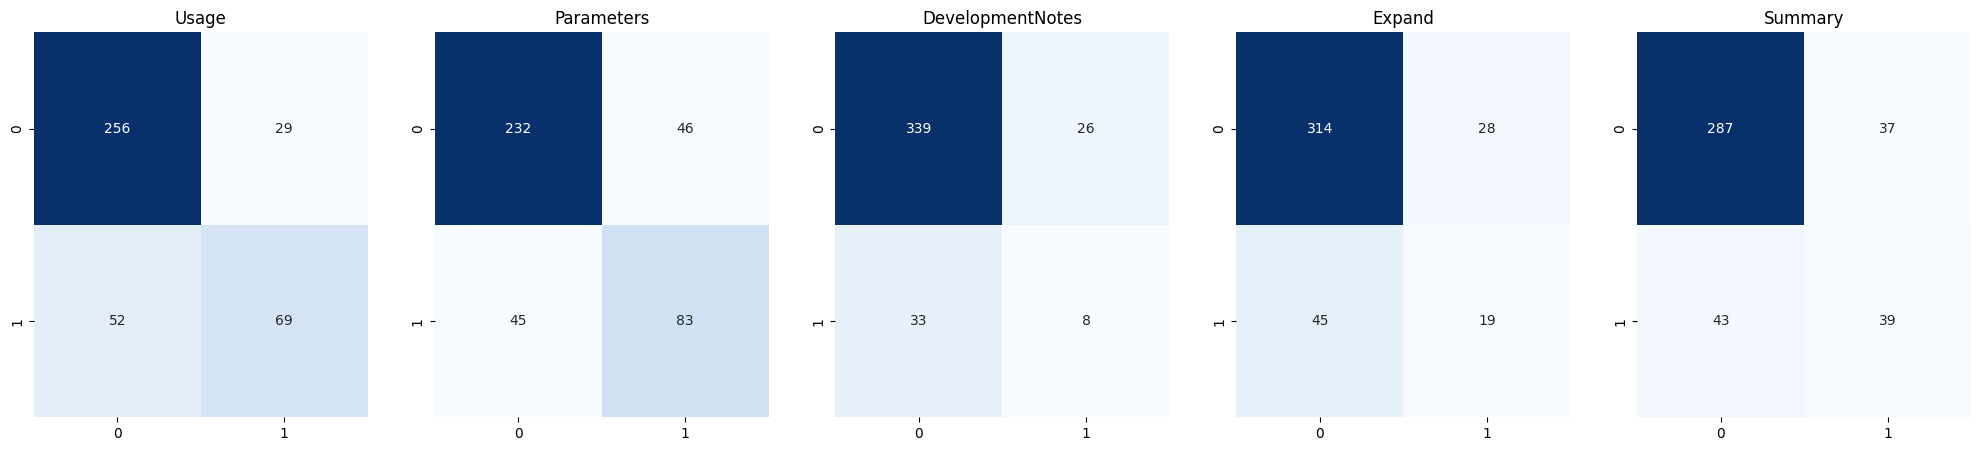

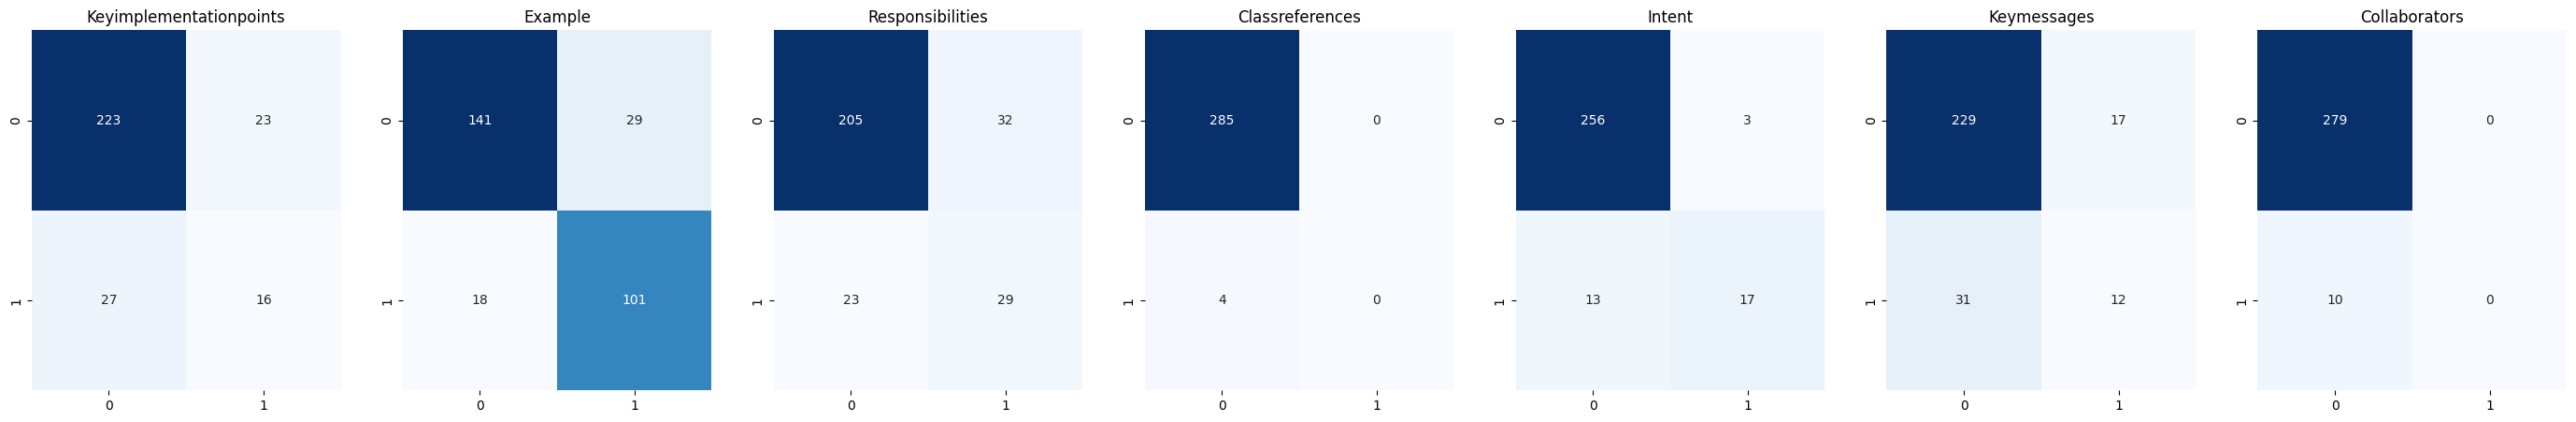

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(true_labels, pred_labels, lang):
    cm = multilabel_confusion_matrix(true_labels, pred_labels)
    fig, ax = plt.subplots(1, len(classification_labels[lang]), figsize=(len(classification_labels[lang])*5, 5))
    for i in range(len(classification_labels[lang])):
        sns.heatmap(cm[i], annot=True, ax=ax[i], fmt='d', cmap='Blues', cbar=False)
        ax[i].set_title(classification_labels[lang][i])
    plt.show()

plot_confusion_matrix(java_true_labels, java_eval_labels, 'java')
plot_confusion_matrix(python_true_labels, python_eval_labels, 'python')
plot_confusion_matrix(pharo_true_labels, pharo_eval_labels, 'pharo')

In [ ]:
# Show examples
def show_examples(model, tokenizer, lang, num_examples=4):
    
    eval_data = preprocess_java(ds[f'{lang}_test']['comment_sentence'], ds[f'{lang}_train']['class'], ds[f'{lang}_test']['labels'])
    eval_dataloader = torch.utils.data.DataLoader(eval_data, batch_size=batch_size, shuffle=False, collate_fn=GPT2_collator(tokenizer, max_length))
    eval_labels, eval_probs = predict(model, eval_dataloader, torch.tensor(lang_thresholds[lang]).to(device))
    eval_labels = np.array(eval_labels)
    eval_probs = np.array(eval_probs)
    true_labels = np.array([sequence['label'] for sequence in eval_data])
    
    print(f'{lang} labels: {classification_labels[lang]}')
    for i in range(num_examples):
        print(f'Example {i+1}:')
        print('Text:', eval_data[i]['text'])
        print('True Labels:', true_labels[i])
        print('Predicted Labels:', eval_labels[i])
        print('Probabilities:', [round(p, 2) for p in eval_probs[i]])
        print()

show_examples(java_model, java_tokenizer, 'java')
show_examples(python_model, python_tokenizer, 'python')
show_examples(pharo_model, pharo_tokenizer, 'pharo')

  0%|          | 0/51 [00:00<?, ?it/s]

python labels: ['Usage', 'Parameters', 'DevelopmentNotes', 'Expand', 'Summary']
Example 1:
Text: abstract cbv mixin that gives access mixins the same customizable
True Labels: [0 0 0 0 1]
Predicted Labels: [0 0 0 1 0]
Probabilities: [0.0, 0.0, 0.01, 0.93, 0.11]

Example 2:
Text: more than one migration matches a name prefix.
True Labels: [0 0 0 0 1]
Predicted Labels: [0 0 1 0 0]
Probabilities: [0.27, 0.41, 0.51, 0.01, 0.02]

Example 3:
Text: stub of an appconfig.
True Labels: [0 0 0 0 1]
Predicted Labels: [0 0 0 0 1]
Probabilities: [0.0, 0.0, 0.0, 0.11, 0.96]

Example 4:
Text: only provides a label and a dict of models.
True Labels: [0 1 0 0 0]
Predicted Labels: [0 0 0 0 1]
Probabilities: [0.0, 0.0, 0.0, 0.0, 1.0]



  0%|          | 0/37 [00:00<?, ?it/s]

pharo labels: ['Keyimplementationpoints', 'Example', 'Responsibilities', 'Classreferences', 'Intent', 'Keymessages', 'Collaborators']
Example 1:
Text: i contain examples of different types of blarrowheadelement
True Labels: [0 0 1 1 0 0 0]
Predicted Labels: [0 0 1 0 0 0 0]
Probabilities: [0.05, 0.02, 0.62, 0.2, 0.1, 0.03, 0.36]

Example 2:
Text: users can also customise nose angle that tells how wide should the arrow lines be spread.
True Labels: [0 1 0 0 0 0 0]
Predicted Labels: [0 0 1 0 0 0 0]
Probabilities: [0.48, 0.02, 0.56, 0.04, 0.01, 0.04, 0.13]

Example 3:
Text: the with of the outer arrows can be specified by changing border width of a simple arrow arrowhead.
True Labels: [0 0 1 0 0 0 0]
Predicted Labels: [1 0 0 0 0 0 0]
Probabilities: [0.73, 0.03, 0.14, 0.02, 0.0, 0.34, 0.04]

Example 4:
Text: i support both background and border paint and can have hollow inner triangle.
True Labels: [0 0 1 0 0 0 0]
Predicted Labels: [0 0 1 0 0 0 0]
Probabilities: [0.01, 0.0, 0.77, 0.02, 0.1,

In [ ]:
#torch.cuda.empty_cache()

In [ ]:
# Run tests on java lang with all hyperparameters
"""
# Hyperparameters
hyperparameters = {
    'num_epochs': [3],
    'batch_size': [4],
    'learning_rate': [1e-5],
    'optimizer': ['Lion'],
    'max_length': [256],
}

for num_epochs in hyperparameters['num_epochs']:
    for batch_size in hyperparameters['batch_size']:
        for learning_rate in hyperparameters['learning_rate']:
            for optimizer in hyperparameters['optimizer']:
                for max_length in hyperparameters['max_length']:
                    print(f'Running test with hyperparameters: num_epochs={num_epochs}, batch_size={batch_size}, learning_rate={learning_rate}, optimizer={optimizer}, max_length={max_length}, weights={class_weights["java"]}')
                    model, tokenizer, loss_list, accuracy_list, eval_loss_list, eval_accuracy_list = build_model('java', save=False, optimizer=optimizer, learning_rate=learning_rate, num_epochs=num_epochs, batch_size=batch_size, max_length=max_length)
                    
                    # Do classification report
                    eval_data = preprocess_java(ds['java_test']['comment_sentence'], ds['java_train']['class'], ds['java_test']['labels'])
                    eval_dataloader = torch.utils.data.DataLoader(eval_data, batch_size=batch_size, shuffle=False, collate_fn=GPT2_collator(tokenizer, max_length))
                    eval_labels = predict(model, eval_dataloader)
                    true_labels = [sequence['label'] for sequence in eval_data]
                    report = classification_report(true_labels, eval_labels, target_names=classification_labels['java'])
                    
                    # Add results to file
                    with open('results.txt', 'a') as f:
                        f.write(f'Java - num_epochs={num_epochs}, batch_size={batch_size}, learning_rate={learning_rate}, optimizer={optimizer}, max_length={max_length}, weights={class_weights["java"]}\n')
                        f.write(f'Loss: {loss_list}\n')
                        f.write(f'Accuracy: {accuracy_list}\n')
                        f.write(f'Eval Loss: {eval_loss_list}\n')
                        f.write(f'Eval Accuracy: {eval_accuracy_list}\n')
                        f.write(f'Report: {report}\n')
                        f.write('\n')
                    
                    num_labels = len(classification_labels['java'])
                    cms = [confusion_matrix(true_labels[:, i], eval_labels[:, i]) for i in range(num_labels)]
                    
                    for i, label in enumerate(classification_labels['java']):
                        plot_confusion_matrix(cms[i], class_names=[0, 1], title=f'Confusion Matrix for {label}')
                    
                    print(report)
"""

'\n# Hyperparameters\nhyperparameters = {\n    \'num_epochs\': [3],\n    \'batch_size\': [4],\n    \'learning_rate\': [1e-5],\n    \'optimizer\': [\'Lion\'],\n    \'max_length\': [256],\n}\n\nfor num_epochs in hyperparameters[\'num_epochs\']:\n    for batch_size in hyperparameters[\'batch_size\']:\n        for learning_rate in hyperparameters[\'learning_rate\']:\n            for optimizer in hyperparameters[\'optimizer\']:\n                for max_length in hyperparameters[\'max_length\']:\n                    print(f\'Running test with hyperparameters: num_epochs={num_epochs}, batch_size={batch_size}, learning_rate={learning_rate}, optimizer={optimizer}, max_length={max_length}, weights={class_weights["java"]}\')\n                    model, tokenizer, loss_list, accuracy_list, eval_loss_list, eval_accuracy_list = build_model(\'java\', save=False, optimizer=optimizer, learning_rate=learning_rate, num_epochs=num_epochs, batch_size=batch_size, max_length=max_length)\n                    